<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/16_Training_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 32.4 MB/s 
     |████████████████████████████████| 1.3 MB 49.1 MB/s 
     |████████████████████████████████| 431 kB 55.6 MB/s 
     |████████████████████████████████| 4.9 MB 56.6 MB/s 
     |████████████████████████████████| 163 kB 60.3 MB/s 
     |████████████████████████████████| 212 kB 70.5 MB/s 
     |████████████████████████████████| 115 kB 28.4 MB/s 
     |████████████████████████████████| 127 kB 69.3 MB/s 
     |████████████████████████████████| 6.6 MB 60.2 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

# The Training Process

The basis of stochastic gradient descentis: pass a mini-batch to the model, compare it to our target with the loss function, then compute the gradients of this loss function with regard to each weight before updating the weights with the formula:

 ***new_weight = weight - lr * weight.grad***


PyTorch provides a simple nn.SGD class that does this calculation for each parameter for us. In this chapter we will build some faster optimizers, using a flexible foundation. But that's not all we might want to change in the training process. For any tweak of the training loop, we will need a way to add some code to the basis of SGD. The fastai library has a system of callbacks to do this, and we will teach you all about it.

Let's start with standard SGD to get a baseline, then we will introduce the most commonly used optimizers.

# Establishing a Baseline

First, we'll create a baseline, using plain SGD, and compare it to fastai's default optimizer. We'll start by grabbing Imagenette with the same get_data

In [3]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [4]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

We'll create a ResNet-34 without pretraining, and pass along any arguments received:

In [5]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

Here's the default fastai optimizer, with the usual 3e-3 learning rate:

In [6]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.554203,2.616651,0.198217,00:40
1,1.989447,2.701750,0.472611,00:30
2,1.627156,1.592437,0.569682,00:30


Now let's try plain SGD. We can pass opt_func (optimization function) to vision_learner to get fastai to use any optimizer:

In [7]:
learn = get_learner(opt_func=SGD)

The first thing to look at is lr_find:

SuggestedLRs(valley=0.010964781977236271)

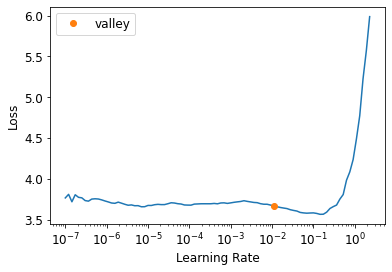

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(3, 0.01, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,3.192619,2.814304,0.196178,00:30
1,2.772745,1.937590,0.328153,00:31
2,2.554292,1.890806,0.341146,00:29


Because accelerating SGD with momentum is such a good idea, fastai does this by default in fit_one_cycle, so we turn it off with moms=(0,0,0). We'll be discussing momentum shortly.)

Clearly, plain SGD isn't training as fast as we'd like. So let's learn some tricks to get accelerated training!

# A Generic Optimizer

To build up our accelerated SGD tricks, we'll need to start with a nice flexible optimizer foundation. No library prior to fastai provided such a foundation, but during fastai's development we realized that all the optimizer improvements we'd seen in the academic literature could be handled using optimizer callbacks. These are small pieces of code that we can compose, mix and match in an optimizer to build the optimizer step. They are called by fastai's lightweight Optimizer class. These are the definitions in Optimizer of the two key methods that we've been using in this book:

In [10]:
def zero_grad(self):
    for p,*_ in self.all_params():
        p.grad.detach_()
        p.grad.zero_()

def step(self):
    for p,pg,state,hyper in self.all_params():
        for cb in self.cbs:
            state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state

As we saw when training an MNIST model from scratch, zero_grad just loops through the parameters of the model and sets the gradients to zero. It also calls detach_, which removes any history of gradient computation, since it won't be needed after zero_grad.

The more interesting method is step, which loops through the callbacks (cbs) and calls them to update the parameters (the _update function just calls state.update if there's anything returned by cb). As you can see, Optimizer doesn't actually do any SGD steps itself. Let's see how we can add SGD to Optimizer.

Here's an optimizer callback that does a single SGD step, by multiplying -lr by the gradients and adding that to the parameter (when Tensor.add_ in PyTorch is passed two parameters, they are multiplied together before the addition):

In [11]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

We can pass this to Optimizer using the cbs parameter; we'll need to use partial since Learner will call this function to create our optimizer later:

In [12]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [13]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.748100,1.957117,0.335541,00:30
1,2.320689,1.840784,0.395669,00:30
2,2.038075,1.661286,0.450446,00:29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  """Entry point for launching an IPython kernel.


It's working! So that's how we create SGD from scratch in fastai. Now let's see what "momentum" is.

# Momentum

SGD can be thought of as standing at the top of a mountain and working your way down by taking a step in the direction of the steepest slope at each point in time. But what if we have a ball rolling down the mountain? It won't, at each given point, exactly follow the direction of the gradient, as it will have momentum. A ball with more momentum (for instance, a heavier ball) will skip over little bumps and holes, and be more likely to get to the bottom of a bumpy mountain. A ping pong ball, on the other hand, will get stuck in every little crevice.

So how can we bring this idea over to SGD? We can use a moving average, instead of only the current gradient, to make our step:


```
weight.avg = beta * weight.avg + (1-beta) * weight.grad
new_weight = weight - lr * weight.avg
```
Here beta is some number we choose which defines how much momentum to use. If beta is 0, then the first equation becomes weight.avg = weight.grad, so we end up with plain SGD. But if it's a number close to 1, then the main direction chosen is an average of the previous steps. 

Note that we are writing weight.avg to highlight the fact that we need to store the moving averages for each parameter of the model (they all have their own independent moving averages).


**Momentum** works particularly well if the loss function has narrow canyons we need to navigate: vanilla SGD would send us bouncing from one side to the other, while SGD with momentum will average those to roll smoothly down the side. The parameter beta determines the strength of the momentum we are using: with a small beta we stay closer to the actual gradient values, whereas with a high beta we will mostly go in the direction of the average of the gradients and it will take a while before any change in the gradients makes that trend move.

With a large beta, we might miss that the gradients have changed directions and roll over a small local minima. This is a desired side effect: intuitively, when we show a new input to our model, it will look like something in the training set but won't be exactly like it. That means it will correspond to a point in the loss function that is close to the minimum we ended up with at the end of training, but not exactly at that minimum. So, we would rather end up training in a wide minimum, where nearby points have approximately the same loss (or if you prefer, a point where the loss is as flat as possible).

In SGD with momentum, a value of beta that is often used is 0.9.

fit_one_cycle by default starts with a beta of 0.95, gradually adjusts it to 0.85, and then gradually moves it back to 0.95 at the end of training. Let's see how our training goes with momentum added to plain SGD.

In order to add momentum to our optimizer, we'll first need to keep track of the moving average gradient, which we can do with another callback. When an optimizer callback returns a dict, it is used to update the state of the optimizer and is passed back to the optimizer on the next step. So this callback will keep track of the gradient averages in a parameter called grad_avg:

In [14]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

To use it, we just have to replace p.grad.data with grad_avg in our step function:

In [15]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [16]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

Learner will automatically schedule mom and lr, so fit_one_cycle will even work with our custom Optimizer:

In [17]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.763870,2.491500,0.244841,00:30
1,2.479771,2.308801,0.353631,00:29
2,2.202719,1.855605,0.410446,00:29


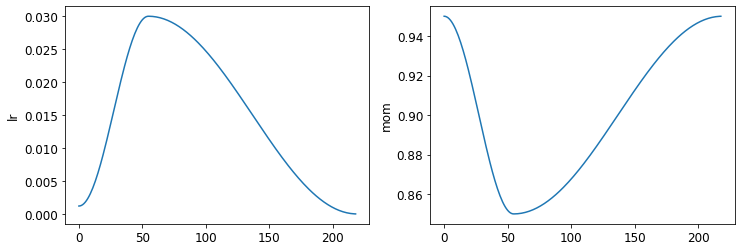

In [18]:
learn.recorder.plot_sched()

# RMSProp

The main difference from SGD is that it uses an adaptive learning rate: instead of using the same learning rate for every parameter, each parameter gets its own specific learning rate controlled by a global learning rate. That way we can speed up training by giving a higher learning rate to the weights that need to change a lot while the ones that are good enough get a lower learning rate.

How do we decide which parameters should have a high learning rate and which should not? We can look at the gradients to get an idea. If a parameter's gradients have been close to zero for a while, that parameter will need a higher learning rate because the loss is flat. On the other hand, if the gradients are all over the place, we should probably be careful and pick a low learning rate to avoid divergence. We can't just average the gradients to see if they're changing a lot, because the average of a large positive and a large negative number is close to zero. Instead, we can use the usual trick of either taking the absolute value or the squared values (and then taking the square root after the mean).

Once again, to determine the general tendency behind the noise, we will use a moving average—specifically the moving average of the gradients squared. Then we will update the corresponding weight by using the current gradient (for the direction) divided by the square root of this moving average (that way if it's low, the effective learning rate will be higher, and if it's high, the effective learning rate will be lower):



```
w.square_avg = alpha * w.square_avg + (1-alpha) * (w.grad ** 2)
new_w = w - lr * w.grad / math.sqrt(w.square_avg + eps)
```



The eps (epsilon) is added for numerical stability (usually set at 1e-8), and the default value for alpha is usually 0.99.

We can add this to Optimizer by doing much the same thing we did for avg_grad, but with an extra **2

In [19]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

And we can define our step function and optimizer as before:

In [20]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

In [21]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.782722,9.647699,0.210191,00:31
1,2.429020,2.046833,0.322038,00:30
2,2.020733,1.651459,0.444586,00:29


We just have to bring these ideas together, and we have Adam, fastai's default optimizer.

# Adam